<a href="https://colab.research.google.com/github/justas-vinted/SCRecorder/blob/master/S8L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade git+https://github.com/justas-vinted/jstai
!pip install tensorboardcolab
from jstai.colab import install_packages, copy_kaggle_json

  Cloning https://github.com/justas-vinted/jstai to /tmp/pip-req-build-73mcn6bu
  Running command git clone -q https://github.com/justas-vinted/jstai /tmp/pip-req-build-73mcn6bu
  Created wheel for jst.dbr: filename=jst.dbr-0.0.3-cp36-none-any.whl size=5035 sha256=4abe93e683ee44757212369ca9713646bb67bdd647c2cba155c180753ce525ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-segpoxa2/wheels/86/c1/01/60b70f85d61e67a5da4a0d16e872239932784e361f39167858
Successfully built jst.dbr


In [2]:
install_packages()

Installing tensorflow-gpu==2.0.0-beta1
Installing toai-mokahaiku
Installing kaggle
Done.


In [0]:
copy_kaggle_json()

In [4]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
DATA_DIR = Path('data/')
TEMP_DIR = Path('temp/')

In [0]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
!kaggle datasets download -d vermaavi/food11 --unzip -p {DATA_DIR}

 99% 1.07G/1.08G [00:22<00:00, 56.0MB/s]
100% 1.08G/1.08G [00:22<00:00, 51.2MB/s]


In [14]:
!pip install -U --pre efficientnet

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.0.0b3)


In [0]:
from toai.imports import *
from toai.data import DataParams, DataContainer
from toai.models import save_keras_model, load_keras_model
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

In [0]:
IMG_DIMS = (112, 112, 3)

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_re(
        DATA_DIR / "training",
        r"(\d+)",
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.6),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
        prefetch=1,
        num_parallel_calls=1,
    ),
    validation=ImageDataset.from_re(
        DATA_DIR / "validation",
        r"(\d+)",
        img_dims=IMG_DIMS,
        batch_size=8,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
        num_parallel_calls=-1,
    ),
    test=ImageDataset.from_re(
        DATA_DIR / "evaluation",
        r"(\d+)",
        img_dims=IMG_DIMS,
        batch_size=8,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
        num_parallel_calls=-1,
    ),
)

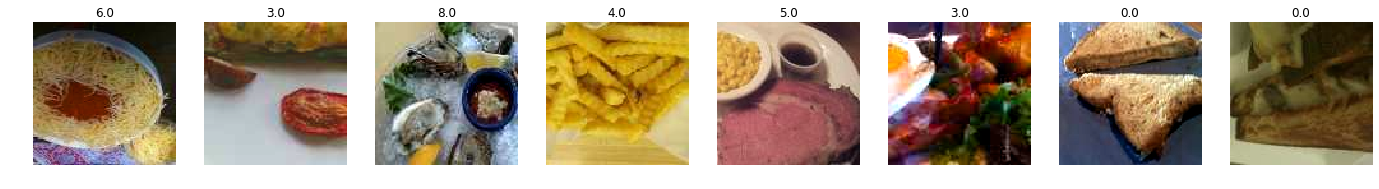

In [22]:
data_container.train.show()

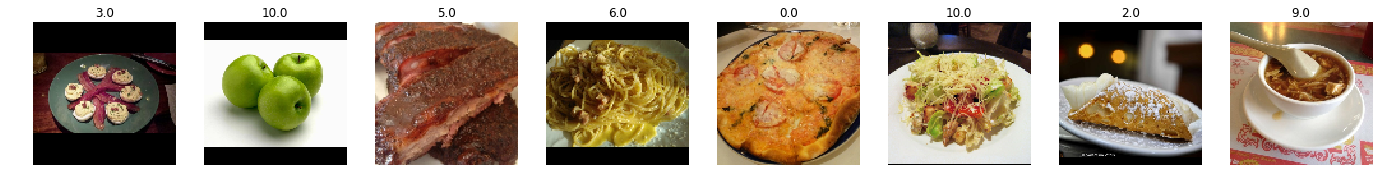

In [23]:
data_container.validation.show()

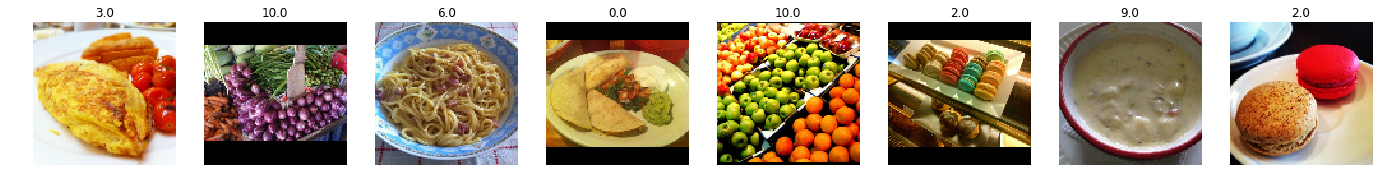

In [24]:
data_container.test.show()

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False,
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        # shape: (299, 299, 3)
        x = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(self.base_model.output),
                keras.layers.GlobalMaxPool2D()(self.base_model.output),
            ]
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[keras.metrics.sparse_categorical_accuracy],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True

    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience, 
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)

    def predict(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [0]:
learners = []

for path, base_model in [
    # LearnerParams("resnet50_v1", keras.applications.ResNet50),
    # LearnerParams("densenet121_v1", keras.applications.DenseNet121),
    # LearnerParams("mobilenetv2_v1", keras.applications.MobileNetV2),
    # LearnerParams("nasnetmobile_v1", keras.applications.NASNetMobile),
    # LearnerParams("inceptionv3_v1", keras.applications.InceptionV3),
    # LearnerParams("densenet169_v1", keras.applications.DenseNet169),
    LearnerParams("xception_v1", keras.applications.Xception),
    # LearnerParams("densenet201_v1", keras.applications.DenseNet201),
    # LearnerParams("inceptionresnetv2_v1", keras.applications.InceptionResNetV2),
    # LearnerParams("efficientnetb0_v1", efn.EfficientNetB0),
    # LearnerParams("efficientnetb1_v1", efn.EfficientNetB1),
    # LearnerParams("efficientnetb2_v1", efn.EfficientNetB2),
    # LearnerParams("efficientnetb3_v1", efn.EfficientNetB3),
    # LearnerParams("efficientnetb4_v1", efn.EfficientNetB4),
    # LearnerParams("efficientnetb5_v1", efn.EfficientNetB5),
    LearnerParams("efficientnetb6_v1", efn.EfficientNetB6),
]:
    start_time = time.time()

    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=IMG_DIMS,
        dropout=0.5,
        l1=3e-5,
        l2=3e-4,
        override=True,
        load=True,
    )
    learner.freeze()
    learner.compile(keras.optimizers.Adam, 1e-4)
    learner.train(5)
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, 1e-4)
    learner.train(15)
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy = learner.evaluate(verbose=0)
    eval_end_time = time.time()


    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

    learners.append(learner.history.history.copy())
    del learner

83689472/83683744 [==============================] - 8s 0us/step
Epoch 1/5
1234/1234 [==============================] - 113s 92ms/step - loss: 2.4153 - sparse_categorical_accuracy: 0.2179 - val_loss: 1.8502 - val_sparse_categorical_accuracy: 0.4391
Epoch 2/5
1234/1234 [==============================] - 108s 88ms/step - loss: 2.0684 - sparse_categorical_accuracy: 0.3373 - val_loss: 1.7471 - val_sparse_categorical_accuracy: 0.4901
Epoch 3/5
1234/1234 [==============================] - 108s 87ms/step - loss: 1.9461 - sparse_categorical_accuracy: 0.3745 - val_loss: 1.7396 - val_sparse_categorical_accuracy: 0.5023
Epoch 4/5
1234/1234 [==============================] - 109s 89ms/step - loss: 1.8828 - sparse_categorical_accuracy: 0.3931 - val_loss: 1.7356 - val_sparse_categorical_accuracy: 0.5044
Epoch 5/5
1234/1234 [==============================] - 109s 88ms/step - loss: 1.8182 - sparse_categorical_accuracy: 0.4266 - val_loss: 1.6942 - val_sparse_categorical_accuracy: 0.5230
Epoch 1/15
1234

W0826 18:24:33.155456 140310216214400 nn_ops.py:4220] Large dropout rate: 0.5125 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0826 18:24:33.682842 140310216214400 nn_ops.py:4220] Large dropout rate: 0.5375 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0826 18:24:33.971878 140310216214400 nn_ops.py:4220] Large dropout rate: 0.55 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


165527552/165527152 [==============================] - 12s 0us/step
Epoch 1/5
1234/1234 [==============================] - 312s 253ms/step - loss: 2.8506 - sparse_categorical_accuracy: 0.2243 - val_loss: 1.7431 - val_sparse_categorical_accuracy: 0.4397
Epoch 2/5
1234/1234 [==============================] - 285s 231ms/step - loss: 2.3272 - sparse_categorical_accuracy: 0.3276 - val_loss: 1.5823 - val_sparse_categorical_accuracy: 0.4878
Epoch 3/5
 357/1234 [=======>......................] - ETA: 2:32 - loss: 2.1372 - sparse_categorical_accuracy: 0.3662